In [1]:
import sys
sys.path.append('../')

In [2]:
import os
import copy

import numpy as np
import pandas as pd
import pickle as pkl

import matplotlib.pyplot as plt

import blo.params as blo_params
from blo.utils import load_problem, factory_get_path

In [3]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
plt.style.reload_library()
plt.style.use(['science'])

In [4]:
dndp_dir = '../dndp/results/'

In [5]:
# load baseline results
f_baseline = 'baseline_results'
baseline_results = pd.read_csv(f'{dndp_dir}{f_baseline}.csv')

In [6]:
# load main paper results
main_result_file = 'ml_results_tml-5_skl-1.0'
main_results = pd.read_csv(f'{dndp_dir}{main_result_file}.csv')

In [7]:
# load appendix results
appendix_lambda_result_file = 'ml_results_tml-5_skl-0.1'
lower_results_smaller_lambda = pd.read_csv(f'{dndp_dir}{appendix_lambda_result_file}.csv')

In [8]:
budgets = set(main_results['budget'])
edges = set(main_results['n_edges'])

In [9]:
def get_res(df, method, budget, n_edges):

    res = df[df['method'] == method]
    res = res[res['budget'] == budget]
    res = res[res['n_edges'] == n_edges]

    return res

In [10]:
cols = [
    'nn_l_obj', 'nn_u_obj', 'gbt_l_obj', 'gbt_u_obj', 'mkkt_5_obj', 'mkkt_10_obj', 'mkkt_30_obj',
    'nn_l_mre', 'nn_u_mre', 'gbt_l_mre', 'gbt_u_mre', 'mkkt_5_mre', 'mkkt_10_mre', 'mkkt_30_mre',
    'nn_l_time', 'nn_u_time', 'gbt_l_time', 'gbt_u_time'
]

In [11]:
# indicies for table
indicies = []
for n_edges in edges:
    for budget in budgets:
        indicies.append(f"{n_edges} & {budget}")

avg = "\\multicolumn{2}{c|}{Average}"
indicies.append(avg)

In [12]:
relative_errors = {}
relative_errors["nn_l"] = {}
relative_errors["nn_u"] = {}
relative_errors["gbt_l"] = {}
relative_errors["gbt_u"] = {}
relative_errors["mkkt_5"] = {}
relative_errors["mkkt_10"] = {}
relative_errors["mkkt_30"] = {}

for n_edges in edges:
    relative_errors["nn_l"][n_edges] = {}
    relative_errors["nn_u"][n_edges] = {}
    relative_errors["gbt_l"][n_edges] = {}
    relative_errors["gbt_u"][n_edges] = {}
    relative_errors["mkkt_5"][n_edges] = {}
    relative_errors["mkkt_10"][n_edges] = {}
    relative_errors["mkkt_30"][n_edges] = {}

In [13]:
df = pd.DataFrame(index=indicies, columns=cols)

In [14]:
for n_edges in edges:
    for budget in budgets:

        # baseline results
        mkkt_5_res = get_res(baseline_results, 'mkkt_5', budget, n_edges)
        mkkt_5_times =  mkkt_5_res['time']
        mkkt_5_obj =  mkkt_5_res['obj']

        mkkt_10_res = get_res(baseline_results, 'mkkt_10', budget, n_edges)
        mkkt_10_times =  mkkt_10_res['time']
        mkkt_10_obj =  mkkt_10_res['obj']

        mkkt_30_res = get_res(baseline_results, 'mkkt_30', budget, n_edges)
        mkkt_30_times =  mkkt_30_res['time']
        mkkt_30_obj =  mkkt_30_res['obj']

        # NN results
        nn_u_res = get_res(main_results, 'nn_upper_0', budget, n_edges)
        nn_u_times =  nn_u_res['time']
        nn_u_obj =  nn_u_res['obj']

        nn_l_res = get_res(main_results, 'nn_lower_0', budget, n_edges)
        nn_l_times =  nn_l_res['time']
        nn_l_obj =  nn_l_res['obj']

        # GBT results
        gbt_u_res = get_res(main_results, 'gbt_upper_0', budget, n_edges)
        gbt_u_times =  gbt_u_res['time']
        gbt_u_obj =  gbt_u_res['obj']

        gbt_l_res = get_res(main_results, 'gbt_lower_0', budget, n_edges)
        gbt_l_times =  gbt_l_res['time']
        gbt_l_obj =  gbt_l_res['obj']

        # compute relative errors
        objs = np.array([mkkt_5_obj, mkkt_10_obj, mkkt_30_obj, nn_l_obj, nn_u_obj, gbt_l_obj, gbt_u_obj])
        best_objs = list(np.min(objs, axis=0))

        mkkt_5_mre =  list(map(lambda x, y: 100 * (x - y)/y, mkkt_5_obj, best_objs))
        mkkt_10_mre =  list(map(lambda x, y: 100 * (x - y)/x, mkkt_10_obj, best_objs))
        mkkt_30_mre =  list(map(lambda x, y: 100 * (x - y)/y, mkkt_30_obj, best_objs))
        
        nn_u_mre =  list(map(lambda x, y: 100 * (x - y)/y, nn_u_obj, best_objs))
        nn_l_mre =  list(map(lambda x, y: 100 * (x - y)/x, nn_l_obj, best_objs))
        gbt_u_mre =  list(map(lambda x, y: 100 * (x - y)/y, gbt_u_obj, best_objs))
        gbt_l_mre =  list(map(lambda x, y: 100 * (x - y)/x, gbt_l_obj, best_objs))

        id = f"{n_edges} & {budget}"
        df['mkkt_5_obj'][id] = np.mean(mkkt_5_obj)
        df['mkkt_10_obj'][id] = np.mean(mkkt_10_obj)
        df['mkkt_30_obj'][id] = np.mean(mkkt_30_obj)
        df['nn_l_obj'][id] = np.mean(nn_l_obj)
        df['nn_u_obj'][id] = np.mean(nn_u_obj)
        df['gbt_l_obj'][id] = np.mean(gbt_l_obj)
        df['gbt_u_obj'][id] = np.mean(gbt_u_obj)

        df['nn_l_time'][id] = np.mean(nn_l_times)
        df['nn_u_time'][id] = np.mean(nn_u_times)
        df['gbt_l_time'][id] = np.mean(gbt_l_times)
        df['gbt_u_time'][id] = np.mean(gbt_u_times)

        df['mkkt_5_mre'][id] = np.mean(mkkt_5_mre)
        df['mkkt_10_mre'][id] = np.mean(mkkt_10_mre)
        df['mkkt_30_mre'][id] = np.mean(mkkt_30_mre)
        df['nn_l_mre'][id] = np.mean(nn_l_mre)
        df['nn_u_mre'][id] = np.mean(nn_u_mre)
        df['gbt_l_mre'][id] = np.mean(gbt_l_mre)
        df['gbt_u_mre'][id] = np.mean(gbt_u_mre)
        
        relative_errors["nn_l"][n_edges][budget] = nn_l_mre
        relative_errors["nn_u"][n_edges][budget] = nn_u_mre
        relative_errors["gbt_l"][n_edges][budget] = gbt_l_mre
        relative_errors["gbt_u"][n_edges][budget] = gbt_u_mre
        relative_errors["mkkt_5"][n_edges][budget] = mkkt_5_mre
        relative_errors["mkkt_10"][n_edges][budget] = mkkt_10_mre
        relative_errors["mkkt_30"][n_edges][budget] = mkkt_30_mre

In [15]:
# compute averages
df['nn_l_mre'][avg] = np.mean(df['nn_l_mre'])
df['nn_u_mre'][avg] = np.mean(df['nn_u_mre'])
df['gbt_l_mre'][avg] = np.mean(df['gbt_l_mre'])
df['gbt_u_mre'][avg] = np.mean(df['gbt_u_mre'])

df['mkkt_5_mre'][avg] = np.mean(df['mkkt_5_mre'])
df['mkkt_10_mre'][avg] = np.mean(df['mkkt_10_mre'])
df['mkkt_30_mre'][avg] = np.mean(df['mkkt_30_mre'])

df['nn_l_time'][avg] = np.mean(df['nn_l_time'])
df['nn_u_time'][avg] = np.mean(df['nn_u_time'])
df['gbt_l_time'][avg] = np.mean(df['gbt_l_time'])
df['gbt_u_time'][avg] = np.mean(df['gbt_u_time'])

In [16]:
def latex_results_main_gbt(df_):
    """ Generate Latex table for results.  """

    df = df_.copy()

    col_order = [
        'nn_l_mre', 'nn_l_time',
        'nn_u_mre', 'nn_u_time', 
        'gbt_l_mre', 'gbt_l_time',
        'gbt_u_mre', 'gbt_u_time', 
        'mkkt_5_mre', 'mkkt_10_mre', 'mkkt_30_mre'
    ]

    df = df[col_order]

    df = df.rename(columns={

        'nn_l_time' : 'Time',
        'nn_u_time' : 'Time\ ',
        'gbt_l_time' : 'Time\ \ ',
        'gbt_u_time' : 'Time\ \ \ ',
        
        'nn_l_mre' : 'MRE',
        'nn_u_mre' : 'MRE\ ',
        'gbt_l_mre' : 'MRE\ \ ',
        'gbt_u_mre' : 'MRE\ \ \ ',
 
        'mkkt_5_mre' : 'MRE-5',
        'mkkt_10_mre' : 'MRE-10',
        'mkkt_30_mre' : 'MRE-30',      
    })

    df = df.style.format(thousands=',', precision=2)        
    
    # bold minimum value in table
    df = df.highlight_min(subset=['MRE',  'MRE\ ',  'MRE\ \ ',  'MRE\ \ \ ', 'MRE-5', 'MRE-10', 'MRE-30'], props='textbf:--rwrap;', axis=1)
    df = df.highlight_min(subset=['Time', 'Time\ ', 'Time\ \ ', 'Time\ \ \ '], props='textbf:--rwrap;', axis=1)

    # caption
    end_str = '}\n\\caption{DNDP results. '
    end_str += 'Each is averaged across 10 instances.  ' 
    end_str += '\\mls{} and \\gbts{} are the ML formulations with slack for the lower-level approximation.  ' 
    end_str += '\\mlu{} and \\gbtu{} are the ML formulation for the upper-level approximation. }\n'
    end_str += '\\label{tab:dndp_results}\n'
    end_str += '\\end{table*}' 

    latex_str = df.to_latex(column_format='cc|rr|rr|rr|rr|rrr').replace('_','\_').replace('nan', '-').replace('#', '\#')

    row_id = "\# of edges & budget"
    
    latex_str2 = (latex_str.splitlines())
    latex_str2.insert(1, '\\toprule')
    latex_str2.insert(2, row_id + ' & \multicolumn{2}{c|}{\\mls}  & \multicolumn{2}{c|}{\\mlu} & \multicolumn{2}{c}{\\gbts} & \multicolumn{2}{c|}{\\gbtu} &  \multicolumn{3}{c}{\\mkkt} \\\\\ ')
    latex_str2.insert(4, '\\midrule')
    latex_str2.insert(-1, '\\bottomrule')
    latex_str2.insert(0, '\\begin{table*}[h]\\centering\\resizebox{1.0\\textwidth}{!}{')
    latex_str2[-1] += end_str

    print("\n".join(latex_str2))
    print()

In [17]:
def latex_results_main(df_):
    """ Generate Latex table for results.  """

    df = df_.copy()

    col_order = [
        'nn_l_mre', 'nn_l_time',
        'nn_u_mre', 'nn_u_time', 
        'mkkt_5_mre', 'mkkt_10_mre', 'mkkt_30_mre'
    ]

    df = df[col_order]

    df = df.rename(columns={

        'nn_l_time' : 'Time',
        'nn_u_time' : 'Time\ ',
        
        'nn_l_mre' : 'MRE',
        'nn_u_mre' : 'MRE\ ',
 
        'mkkt_5_mre' : 'MRE-5',
        'mkkt_10_mre' : 'MRE-10',
        'mkkt_30_mre' : 'MRE-30',      
    })

    df = df.style.format(thousands=',', precision=2)        
    
    # bold minimum value in table
    df = df.highlight_min(subset=['MRE',  'MRE\ ', 'MRE-5', 'MRE-10', 'MRE-30'], props='textbf:--rwrap;', axis=1)
    df = df.highlight_min(subset=['Time', 'Time\ ', ], props='textbf:--rwrap;', axis=1)

    # caption
    end_str = '}\n\\caption{DNDP results. '
    end_str += 'Each is averaged across 10 instances.  ' 
    end_str += '\\mls{} and \\gbts{} are the ML formulations with slack for the lower-level approximation.  ' 
    end_str += '\\mlu{} and \\gbtu{} are the ML formulation for the upper-level approximation. }\n'
    end_str += '\\label{tab:dndp_results}\n'
    end_str += '\\end{table*}' 

    latex_str = df.to_latex(column_format='cc|rr|rr|rrr').replace('_','\_').replace('nan', '-').replace('#', '\#')

    row_id = "\# of edges & budget"
    
    latex_str2 = (latex_str.splitlines())
    latex_str2.insert(1, '\\toprule')
    latex_str2.insert(2, row_id + ' & \multicolumn{2}{c|}{\\mls}  & \multicolumn{2}{c|}{\\mlu} & \multicolumn{2}{c}{\\gbts} & \multicolumn{2}{c|}{\\gbtu} &  \multicolumn{3}{c}{\\mkkt} \\\\\ ')
    latex_str2.insert(4, '\\midrule')
    latex_str2.insert(-1, '\\bottomrule')
    latex_str2.insert(0, '\\begin{table*}[h]\\centering\\resizebox{1.0\\textwidth}{!}{')
    latex_str2[-1] += end_str

    print("\n".join(latex_str2))
    print()

In [18]:
latex_results_main(df)

\begin{table*}[h]\centering\resizebox{1.0\textwidth}{!}{
\begin{tabular}{cc|rr|rr|rrr}
\toprule
\# of edges & budget & \multicolumn{2}{c|}{\mls}  & \multicolumn{2}{c|}{\mlu} & \multicolumn{2}{c}{\gbts} & \multicolumn{2}{c|}{\gbtu} &  \multicolumn{3}{c}{\mkkt} \\\ 
 & MRE & Time & MRE\  & Time\  & MRE-5 & MRE-10 & MRE-30 \\
\midrule
10 & 0.25 & 1.21 & 2.95 & 0.36 & \textbf{0.01} & 5.78 & 0.51 & \textbf{0.10} \\
10 & 0.5 & 0.73 & 3.35 & 1.22 & \textbf{0.01} & 6.47 & 2.17 & \textbf{0.00} \\
10 & 0.75 & 0.47 & 2.80 & 1.32 & \textbf{0.00} & 5.80 & \textbf{0.02} & 0.06 \\
20 & 0.25 & 6.05 & 5.02 & 2.64 & \textbf{0.02} & 7.78 & 5.12 & \textbf{0.85} \\
20 & 0.5 & 1.01 & 4.91 & 4.36 & \textbf{0.03} & 6.00 & 2.52 & \textbf{0.64} \\
20 & 0.75 & 0.85 & 4.47 & 0.91 & \textbf{0.01} & 7.87 & 0.22 & \textbf{0.11} \\
\multicolumn{2}{c|}{Average} & 1.72 & 3.92 & 1.80 & \textbf{0.01} & 6.62 & 1.76 & \textbf{0.29} \\
\bottomrule
\end{tabular}}
\caption{DNDP results. Each is averaged across 10 instances.  

# Appendix: Objective Results

In [19]:
def latex_appendix_results(df_):
    """ Generate Latex table for results.  """

    df = df_.copy()

    df = df.drop(avg)
    
    df = df.rename(columns={
        'nn_l_obj' : '\\mls',
        'nn_u_obj' : '\\mlu',
        'gbt_l_obj' : '\\gbts',
        'gbt_u_obj' : '\\gbtu',
        'mkkt_5_obj' : '\\mkkt{-5}',
        'mkkt_10_obj' : '\\mkkt{-10}',
        'mkkt_30_obj' : '\\mkkt{-30}',

        'nn_l_time' : '\\mls\ ',
        'nn_u_time' : '\\mlu\ ',
        'gbt_l_time' : '\\gbts\ ',
        'gbt_u_time' : '\\gbtu\ ',
        
        'nn_l_mre' : '\\mls\ \ ',
        'nn_u_mre' : '\\mlu\ \ ',
        'gbt_l_mre' : '\\gbts\ \ ',
        'gbt_u_mre' : '\\gbtu\ \ ',
        'mkkt_5_mre' : '\\mkkt{-5}\ \ ',
        'mkkt_10_mre' : '\\mkkt{-10}\ \ ',
        'mkkt_30_mre' : '\\mkkt{-30}\ \ ',        
    })

    df = df.style.format(thousands=',', precision=2)        
    
    # bold minimum value in table
    df = df.highlight_min(subset=['\\mls',     '\\mlu',     '\\gbts',     '\\gbtu',     '\\mkkt{-5}',     '\\mkkt{-10}',     '\\mkkt{-30}'     ], props='textbf:--rwrap;', axis=1)
    df = df.highlight_min(subset=['\\mls\ ',   '\\mlu\ ',   '\\gbts\ ',   '\\gbtu\ '], props='textbf:--rwrap;', axis=1)
    df = df.highlight_min(subset=['\\mls\ \ ', '\\mlu\ \ ', '\\gbts\ \ ', '\\gbtu\ \ ',  '\\mkkt{-5}\ \ ', '\\mkkt{-10}\ \ ', '\\mkkt{-30}\ \ '], props='textbf:--rwrap;', axis=1)

    # caption
    end_str = '}\n\\caption{DNDP results. '
    end_str += 'Each is averaged across 10 instances.  ' 
    end_str += '\\mls{} and \\gbts{} are the ML formulations with slack for the lower-level approximation.  ' 
    end_str += '\\mlu{} and \\gbtu{} are the ML formulation for the upper-level approximation. }\n'
    end_str += '\\label{tab:dndp_results}\n'
    end_str += '\\end{table*}' 

    latex_str = df.to_latex(column_format='l|l|rrrrrrr|rrrrrrr|rrrr').replace('_','\_').replace('nan', '-').replace('#', '\#')

    row_id = "\# of edges & budget"
    
    latex_str2 = (latex_str.splitlines())
    latex_str2.insert(1, '\\toprule')
    latex_str2.insert(2, row_id + ' & \multicolumn{7}{c|}{Objective}  &  \multicolumn{7}{c|}{Relative Error (\%)}  & \multicolumn{4}{c}{Times} \\\\')
    latex_str2.insert(4, '\\midrule')
    latex_str2.insert(-1, '\\bottomrule')
    latex_str2.insert(0, '\\begin{table*}[h]\\centering\\resizebox{1.0\\textwidth}{!}{')
    latex_str2[-1] += end_str

    print("\n".join(latex_str2))
    print()

In [20]:
latex_appendix_results(df)

\begin{table*}[h]\centering\resizebox{1.0\textwidth}{!}{
\begin{tabular}{l|l|rrrrrrr|rrrrrrr|rrrr}
\toprule
\# of edges & budget & \multicolumn{7}{c|}{Objective}  &  \multicolumn{7}{c|}{Relative Error (\%)}  & \multicolumn{4}{c}{Times} \\
 & \mls & \mlu & \gbts & \gbtu & \mkkt{-5} & \mkkt{-10} & \mkkt{-30} & \mls\ \  & \mlu\ \  & \gbts\ \  & \gbtu\ \  & \mkkt{-5}\ \  & \mkkt{-10}\ \  & \mkkt{-30}\ \  & \mls\  & \mlu\  & \gbts\  & \gbtu\  \\
\midrule
10 & 0.25 & 6,201.25 & 6,145.27 & 6,214.37 & 6,147.02 & 6,484.98 & 6,155.69 & \textbf{6,129.65} & 1.21 & 0.36 & 1.43 & 0.38 & 5.78 & 0.51 & \textbf{0.10} & 2.95 & \textbf{0.01} & 3.19 & 0.09 \\
10 & 0.5 & 5,532.92 & 5,557.28 & 5,531.27 & 5,640.77 & 5,849.03 & 5,618.41 & \textbf{5,492.23} & 0.73 & 1.22 & 0.72 & 2.74 & 6.47 & 2.17 & \textbf{0.00} & 3.35 & \textbf{0.01} & 3.66 & 0.07 \\
10 & 0.75 & 5,202.82 & 5,246.29 & 5,211.07 & 5,225.02 & 5,477.72 & \textbf{5,179.39} & 5,181.30 & 0.47 & 1.32 & 0.63 & 0.91 & 5.80 & \textbf{0.02} & 0.06 & 2.8

# Appendix: Box Plot

In [21]:
def plot_for_edges(relative_errors, edges):
    # copy and convert to lists
    re = copy.deepcopy(relative_errors)
    re['nn_l'][edges] = list(re['nn_l'][edges].values())
    re['nn_u'][edges] = list(re['nn_u'][edges].values())
    
    re['gbt_l'][edges] = list(re['gbt_l'][edges].values())
    re['gbt_u'][edges] = list(re['gbt_u'][edges].values())

    re['mkkt_5'][edges] = list(re['mkkt_5'][edges].values())
    re['mkkt_10'][edges] = list(re['mkkt_10'][edges].values())
    re['mkkt_30'][edges] = list(re['mkkt_30'][edges].values())

    colors = ['#8DDFCB', '#82A0D8', '#EDB7ED', '#ECEE81', '#ffa500', '#ce3231', '#9c45ba',]
    
    # combine data
    data_groups = [re['nn_l'][edges], re['nn_u'][edges], 
                   re['gbt_l'][edges], re['gbt_u'][edges],
                   re['mkkt_5'][edges],  re['mkkt_10'][edges],  re['mkkt_30'][edges]]

    # labels
    labels = list(budgets)
    
    # widths
    width       = 1/len(labels)
    xlocations  = [ x*((1+ len(data_groups))*width) for x in range(len(data_groups[0])) ]
    
    ymin        = min ( [ val  for dg in data_groups  for data in dg for val in data ] )
    ymax        = max ( [ val  for dg in data_groups  for data in dg for val in data ])
    
    fontsize = 16
    
    with plt.style.context(['science', 'nature', 'bright']):
    
        fig, ax = plt.subplots(figsize=(14,4), dpi=300)
    
        ax = plt.gca()
    
        space = len(data_groups)/2
        offset = len(data_groups)/2
    
        # --- Offset the positions per group:
    
        group_positions = []
        for num, dg in enumerate(data_groups):    
            _off = (0 - space + (0.5+num))
            group_positions.append([x+_off*(width+0.01) for x in xlocations])
    
        for dg, pos, c in zip(data_groups, group_positions, colors):
            boxes = ax.boxplot(dg, 
                        labels=['']*len(labels),
                        positions=pos, 
                        widths=width, 
                        boxprops=dict(facecolor=c),                    
                        patch_artist=True)
    
        # # legends
        custom_lines = [
            Line2D([0], [0], color=colors[0], lw=4),
            Line2D([0], [0], color=colors[1], lw=4),
            Line2D([0], [0], color=colors[2], lw=4),
            Line2D([0], [0], color=colors[3], lw=4),
            Line2D([0], [0], color=colors[4], lw=4),
            Line2D([0], [0], color=colors[5], lw=4),
            Line2D([0], [0], color=colors[6], lw=4),
        ]
        
        ax.legend(custom_lines,['NN$^l$', 'NN$^u$', 
                                'GBT$^l$', 'GBT$^u$', 
                                'MKKT-5', 'MKKT-10', 'MKKT-30'], fontsize=12)
    
    
        ax.set_xticks(xlocations)#, fontsize=fontsize)
        ax.set_xticklabels(labels, rotation=0)
    
        ax.set_ylabel('Relative Error', fontsize=fontsize)
        ax.set_xlabel('Budget', fontsize=fontsize)
    
        plt.yticks(fontsize=fontsize)  
        plt.xticks(fontsize=fontsize)    

        plt.savefig(f"figs/bp_dndp_{edges}.pdf")
        
        plt.show()

        

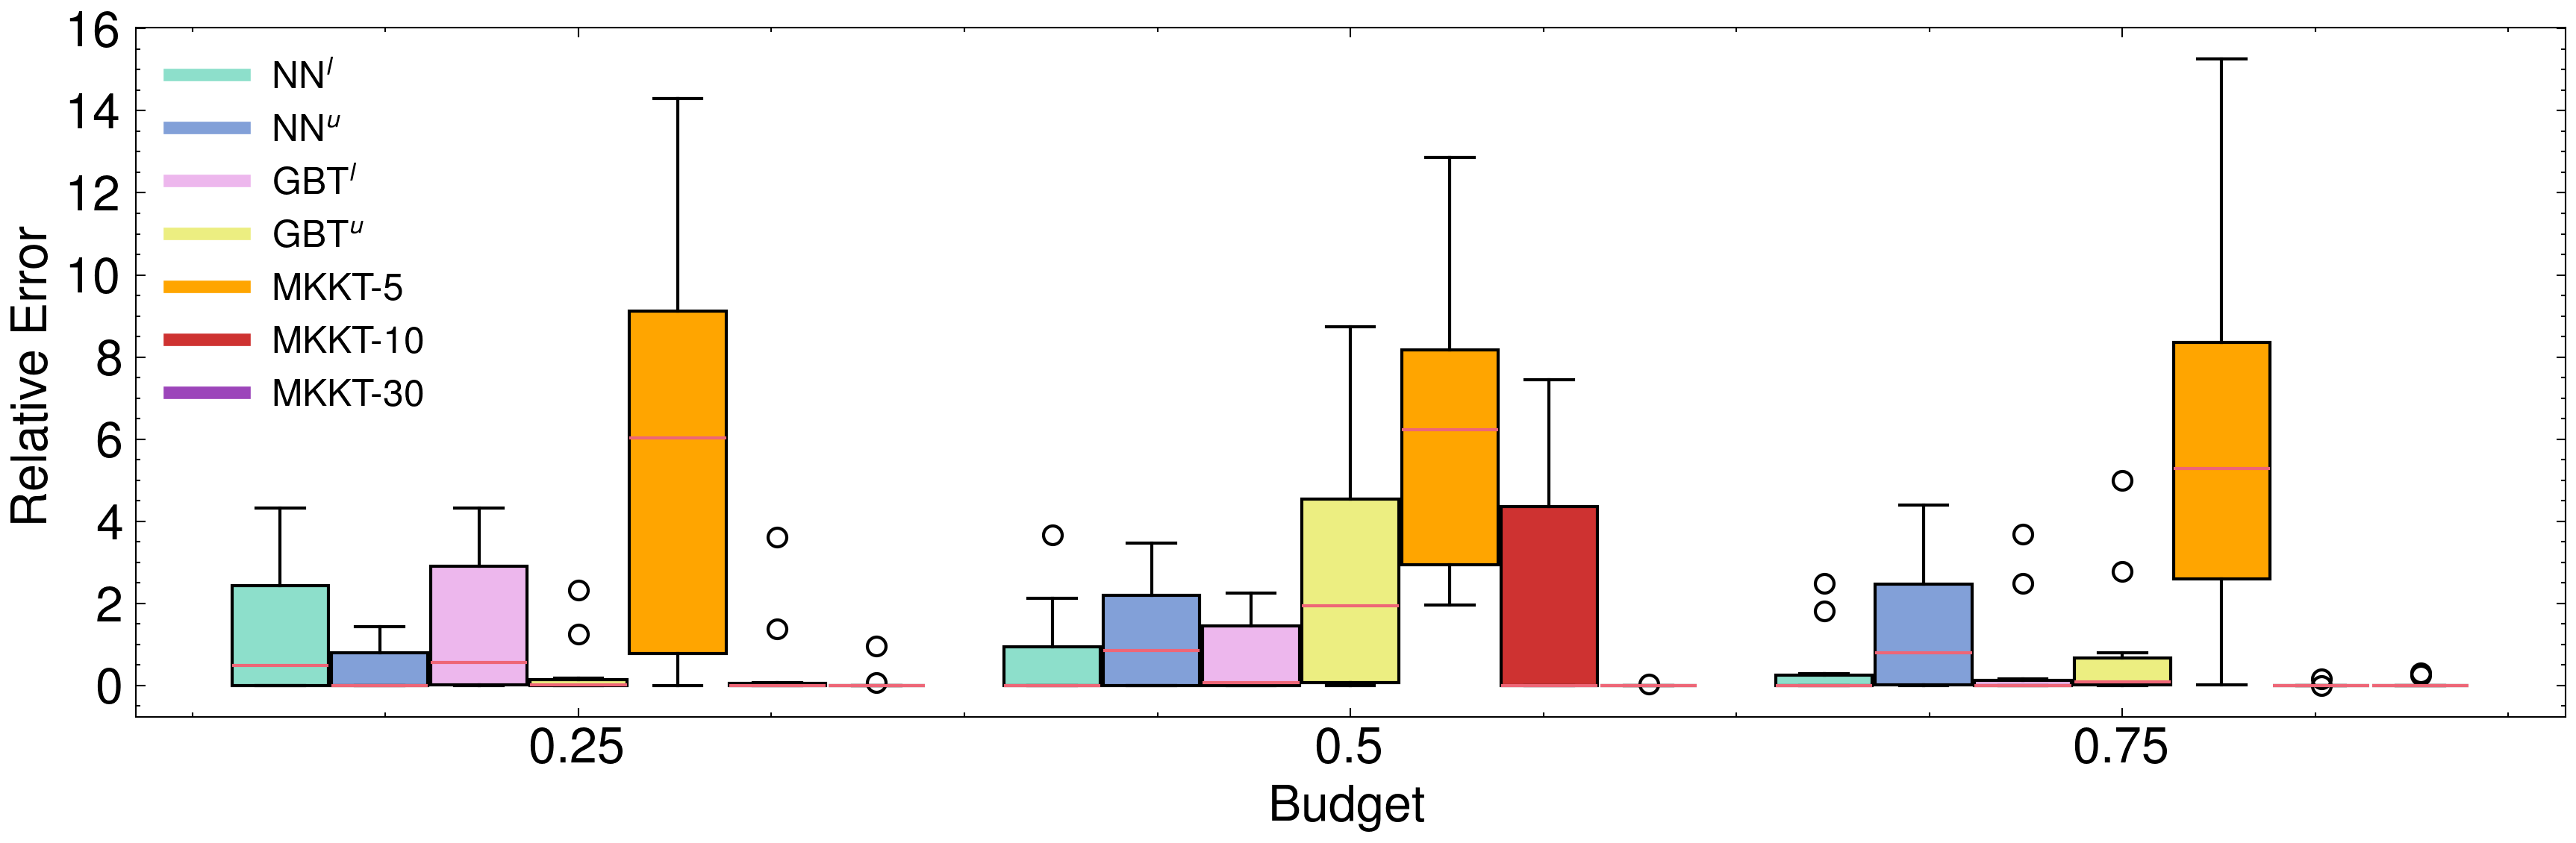

In [22]:
plot_for_edges(relative_errors, 10)

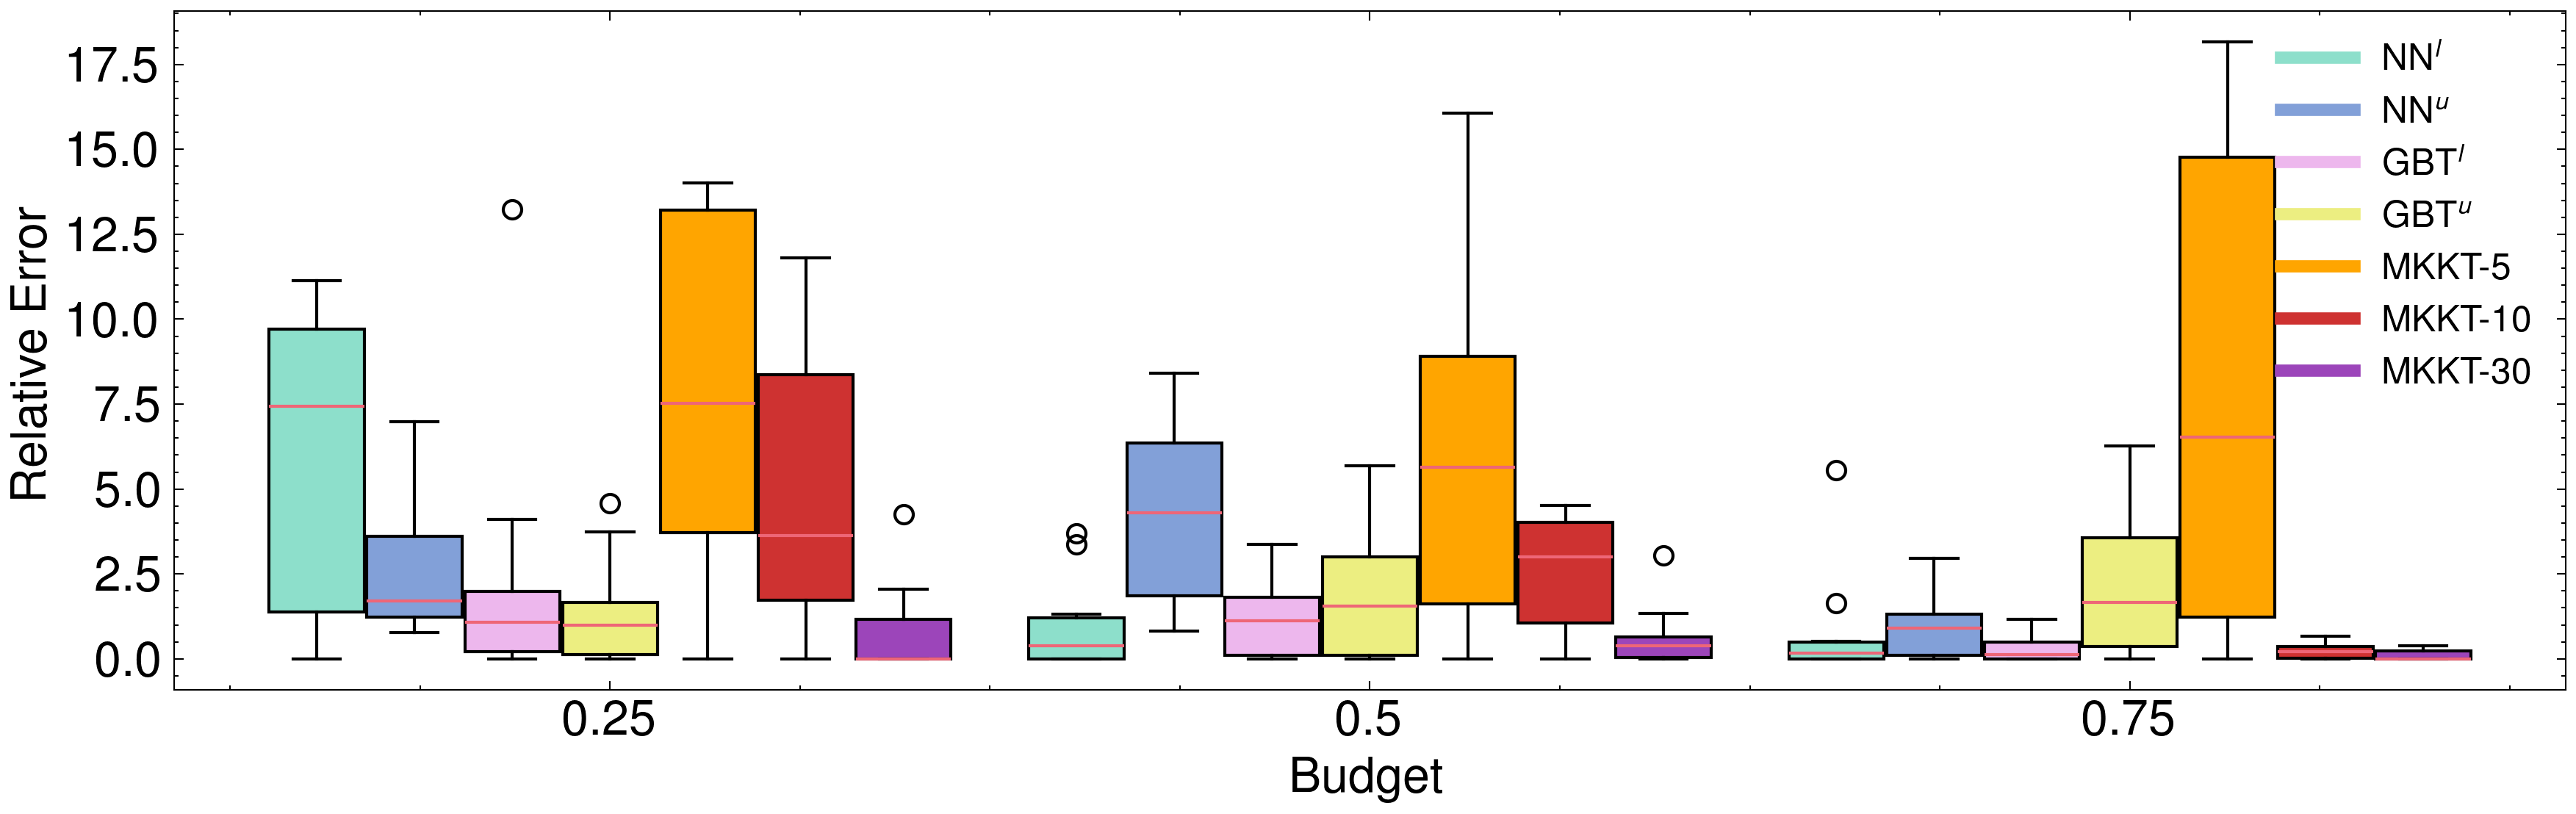

In [23]:
plot_for_edges(relative_errors, 20)

# Appendix: Lower $\lambda$

In [24]:
cols = [
    'nn_l_obj', 'nn_u_obj', 'gbt_l_obj', 'gbt_u_obj', 'mkkt_5_obj', 'mkkt_10_obj', 'mkkt_30_obj',
    'nn_l_mre', 'nn_u_mre', 'gbt_l_mre', 'gbt_u_mre', 'mkkt_5_mre', 'mkkt_10_mre', 'mkkt_30_mre',
    'nn_l_time', 'nn_u_time', 'gbt_l_time', 'gbt_u_time'
]

In [25]:
# indicies for table
indicies = []
for n_edges in edges:
    for budget in budgets:
        indicies.append(f"{n_edges} & {budget}")

avg = "\\multicolumn{2}{c|}{Average}"
indicies.append(avg)

In [26]:
relative_errors = {}
relative_errors["nn_l"] = {}
relative_errors["nn_u"] = {}
relative_errors["gbt_l"] = {}
relative_errors["gbt_u"] = {}
relative_errors["mkkt_5"] = {}
relative_errors["mkkt_10"] = {}
relative_errors["mkkt_30"] = {}

for n_edges in edges:
    relative_errors["nn_l"][n_edges] = {}
    relative_errors["nn_u"][n_edges] = {}
    relative_errors["gbt_l"][n_edges] = {}
    relative_errors["gbt_u"][n_edges] = {}
    relative_errors["mkkt_5"][n_edges] = {}
    relative_errors["mkkt_10"][n_edges] = {}
    relative_errors["mkkt_30"][n_edges] = {}

In [27]:
df = pd.DataFrame(index=indicies, columns=cols)
for n_edges in edges:
    for budget in budgets:

        # baseline results
        mkkt_5_res = get_res(baseline_results, 'mkkt_5', budget, n_edges)
        mkkt_5_times =  mkkt_5_res['time']
        mkkt_5_obj =  mkkt_5_res['obj']

        mkkt_10_res = get_res(baseline_results, 'mkkt_10', budget, n_edges)
        mkkt_10_times =  mkkt_10_res['time']
        mkkt_10_obj =  mkkt_10_res['obj']

        mkkt_30_res = get_res(baseline_results, 'mkkt_30', budget, n_edges)
        mkkt_30_times =  mkkt_30_res['time']
        mkkt_30_obj =  mkkt_30_res['obj']

        # NN results
        nn_u_res = get_res(main_results, 'nn_upper_0', budget, n_edges)
        nn_u_times =  nn_u_res['time']
        nn_u_obj =  nn_u_res['obj']

        nn_l_res = get_res(lower_results_smaller_lambda, 'nn_lower_0', budget, n_edges)
        nn_l_times =  nn_l_res['time']
        nn_l_obj =  nn_l_res['obj']

        # GBT results
        gbt_u_res = get_res(main_results, 'gbt_upper_0', budget, n_edges)
        gbt_u_times =  gbt_u_res['time']
        gbt_u_obj =  gbt_u_res['obj']

        gbt_l_res = get_res(lower_results_smaller_lambda, 'gbt_lower_0', budget, n_edges)
        gbt_l_times =  gbt_l_res['time']
        gbt_l_obj =  gbt_l_res['obj']

        # compute relative errors
        objs = np.array([mkkt_5_obj, mkkt_10_obj, mkkt_30_obj, nn_l_obj, nn_u_obj, gbt_l_obj, gbt_u_obj])
        best_objs = list(np.min(objs, axis=0))

        mkkt_5_mre =  list(map(lambda x, y: 100 * (x - y)/y, mkkt_5_obj, best_objs))
        mkkt_10_mre =  list(map(lambda x, y: 100 * (x - y)/x, mkkt_10_obj, best_objs))
        mkkt_30_mre =  list(map(lambda x, y: 100 * (x - y)/y, mkkt_30_obj, best_objs))
        
        nn_u_mre =  list(map(lambda x, y: 100 * (x - y)/y, nn_u_obj, best_objs))
        nn_l_mre =  list(map(lambda x, y: 100 * (x - y)/x, nn_l_obj, best_objs))
        gbt_u_mre =  list(map(lambda x, y: 100 * (x - y)/y, gbt_u_obj, best_objs))
        gbt_l_mre =  list(map(lambda x, y: 100 * (x - y)/x, gbt_l_obj, best_objs))

        id = f"{n_edges} & {budget}"
        df['mkkt_5_obj'][id] = np.mean(mkkt_5_obj)
        df['mkkt_10_obj'][id] = np.mean(mkkt_10_obj)
        df['mkkt_30_obj'][id] = np.mean(mkkt_30_obj)
        df['nn_l_obj'][id] = np.mean(nn_l_obj)
        df['nn_u_obj'][id] = np.mean(nn_u_obj)
        df['gbt_l_obj'][id] = np.mean(gbt_l_obj)
        df['gbt_u_obj'][id] = np.mean(gbt_u_obj)

        df['nn_l_time'][id] = np.mean(nn_l_times)
        df['nn_u_time'][id] = np.mean(nn_u_times)
        df['gbt_l_time'][id] = np.mean(gbt_l_times)
        df['gbt_u_time'][id] = np.mean(gbt_u_times)

        df['mkkt_5_mre'][id] = np.mean(mkkt_5_mre)
        df['mkkt_10_mre'][id] = np.mean(mkkt_10_mre)
        df['mkkt_30_mre'][id] = np.mean(mkkt_30_mre)
        df['nn_l_mre'][id] = np.mean(nn_l_mre)
        df['nn_u_mre'][id] = np.mean(nn_u_mre)
        df['gbt_l_mre'][id] = np.mean(gbt_l_mre)
        df['gbt_u_mre'][id] = np.mean(gbt_u_mre)

        
        relative_errors["nn_l"][n_edges][budget] = nn_l_mre
        relative_errors["nn_u"][n_edges][budget] = nn_u_mre
        relative_errors["gbt_l"][n_edges][budget] = gbt_l_mre
        relative_errors["gbt_u"][n_edges][budget] = gbt_u_mre
        relative_errors["mkkt_5"][n_edges][budget] = mkkt_5_mre
        relative_errors["mkkt_10"][n_edges][budget] = mkkt_10_mre
        relative_errors["mkkt_30"][n_edges][budget] = mkkt_30_mre


In [28]:
# compute averages
df['nn_l_mre'][avg] = np.mean(df['nn_l_mre'])
df['nn_u_mre'][avg] = np.mean(df['nn_u_mre'])
df['gbt_l_mre'][avg] = np.mean(df['gbt_l_mre'])
df['gbt_u_mre'][avg] = np.mean(df['gbt_u_mre'])

df['mkkt_5_mre'][avg] = np.mean(df['mkkt_5_mre'])
df['mkkt_10_mre'][avg] = np.mean(df['mkkt_10_mre'])
df['mkkt_30_mre'][avg] = np.mean(df['mkkt_30_mre'])

df['nn_l_time'][avg] = np.mean(df['nn_l_time'])
df['nn_u_time'][avg] = np.mean(df['nn_u_time'])
df['gbt_l_time'][avg] = np.mean(df['gbt_l_time'])
df['gbt_u_time'][avg] = np.mean(df['gbt_u_time'])

In [29]:
latex_results_main_gbt(df)

\begin{table*}[h]\centering\resizebox{1.0\textwidth}{!}{
\begin{tabular}{cc|rr|rr|rr|rr|rrr}
\toprule
\# of edges & budget & \multicolumn{2}{c|}{\mls}  & \multicolumn{2}{c|}{\mlu} & \multicolumn{2}{c}{\gbts} & \multicolumn{2}{c|}{\gbtu} &  \multicolumn{3}{c}{\mkkt} \\\ 
 & MRE & Time & MRE\  & Time\  & MRE\ \  & Time\ \  & MRE\ \ \  & Time\ \ \  & MRE-5 & MRE-10 & MRE-30 \\
\midrule
10 & 0.25 & 2.44 & 2.63 & 0.36 & \textbf{0.01} & 1.43 & 3.26 & 0.38 & 0.09 & 5.78 & 0.51 & \textbf{0.10} \\
10 & 0.5 & 0.39 & 2.90 & 1.22 & \textbf{0.01} & 1.33 & 3.54 & 2.74 & 0.07 & 6.47 & 2.17 & \textbf{0.00} \\
10 & 0.75 & 0.48 & 2.23 & 1.32 & \textbf{0.00} & 0.47 & 2.19 & 0.91 & 0.06 & 5.80 & \textbf{0.02} & 0.06 \\
20 & 0.25 & 3.62 & 5.02 & 2.46 & \textbf{0.02} & 1.36 & 5.02 & 1.23 & 0.23 & 7.59 & 4.96 & \textbf{0.67} \\
20 & 0.5 & 1.56 & 4.91 & 4.41 & \textbf{0.03} & 0.98 & 5.02 & 2.06 & 0.21 & 6.05 & 2.57 & \textbf{0.69} \\
20 & 0.75 & \textbf{0.17} & 3.44 & 1.03 & \textbf{0.01} & 0.43 & 4.75 & 2.27